In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization,
                                     Reshape, Bidirectional, LSTM, Dropout, Dense)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# ============ Parameters ============
IMG_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 3  # low, moderate, high

# ============ Data Loaders ============
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    'train',  # folder with subfolders: low, moderate, high
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = val_gen.flow_from_directory(
    'validation',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = test_gen.flow_from_directory(
    'test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important for matching predictions to labels
)

# ============ Model Architecture (CNN-BiLSTM) ============
input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# CNN Feature Extractor
x = BatchNormalization()(input_layer)
x = Conv2D(64, (5, 7), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 3))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 3))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

# BiLSTM
x = Reshape((x.shape[1] * x.shape[2], x.shape[3]))(x)
x = Bidirectional(LSTM(256))(x)

# Dense Layers
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

# Build and Compile Model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# ============ Training ============
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('cnn_bilstm_best.h5', save_best_only=True)
]

model.fit(train_data,
          validation_data=val_data,
          epochs=EPOCHS,
          callbacks=callbacks,
          verbose=2)

# Save Final Model
model.save("cnn_bilstm_final.h5")
print("Model saved as cnn_bilstm_final.h5")

# ============ Evaluate on Test Data ============
loss, acc = model.evaluate(test_data, verbose=2)
print(f"\nTest Accuracy: {acc*100:.2f}%, Test Loss: {loss:.4f}")

# ============ Predictions ============
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_data.classes
class_labels = list(test_data.class_indices.keys())

# ============ Confusion Matrix ============
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# ============ Classification Report ============
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# ============ ROC Curve and AUC ============
# One-hot encode y_true
y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))

# Compute ROC and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_pred_probs[:, i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


Found 720 images belonging to 3 classes.
Found 90 images belonging to 3 classes.
Found 90 images belonging to 3 classes.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      6784      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 85, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 85, 64)       36928     
      

KeyboardInterrupt: 

Found 720 images belonging to 3 classes.
Found 90 images belonging to 3 classes.
Found 90 images belonging to 3 classes.
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 batch_normalization_2 (Batc  (None, 256, 256, 3)      12        
 hNormalization)                                                 
                                                                 
 conv2d_14 (Conv2D)          (None, 256, 256, 64)      6784      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 85, 64)      0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 85, 64)       36928     
    

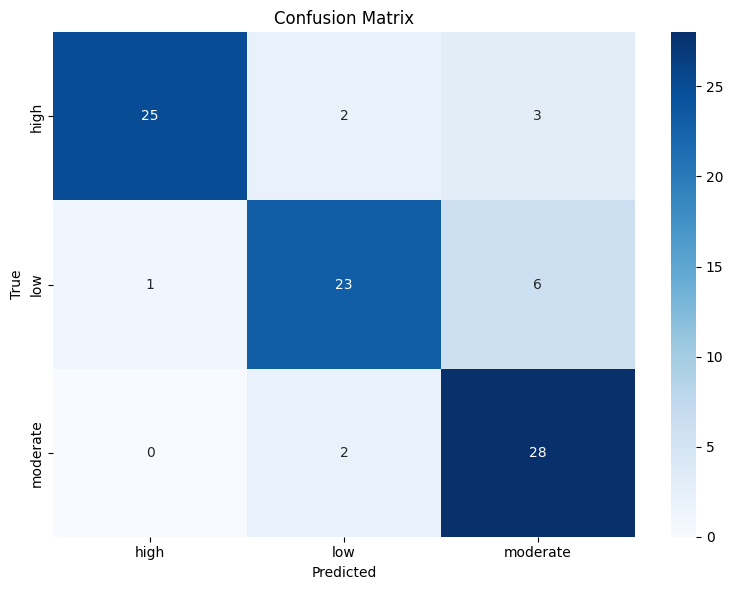


Classification Report:
              precision    recall  f1-score   support

        high       0.96      0.83      0.89        30
         low       0.85      0.77      0.81        30
    moderate       0.76      0.93      0.84        30

    accuracy                           0.84        90
   macro avg       0.86      0.84      0.85        90
weighted avg       0.86      0.84      0.85        90



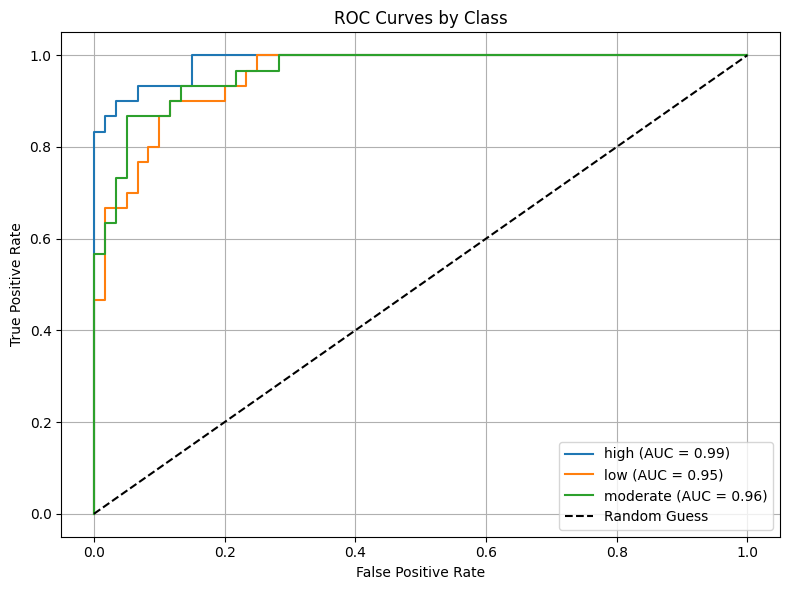

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization,
                                     Reshape, LSTM, Dropout, Dense)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
from sklearn.preprocessing import label_binarize

# ============ Parameters ============
IMG_SIZE = 256
BATCH_SIZE = 16
EPOCHS = 200
NUM_CLASSES = 3  # low, moderate, high

# ============ Data Loaders ============
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    'train',  # folder with subfolders: low, moderate, high
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = val_gen.flow_from_directory(
    'validation',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = test_gen.flow_from_directory(
    'test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important for matching predictions to labels
)

# ============ Model Architecture (CNN-LSTM) ============
input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# CNN Feature Extractor
x = BatchNormalization()(input_layer)
x = Conv2D(64, (5, 7), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 3))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 3))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

# LSTM
x = Reshape((x.shape[1] * x.shape[2], x.shape[3]))(x)
x = LSTM(256)(x)

# Dense Layers
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

# Build and Compile Model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall'),
                  tf.keras.metrics.AUC(name='auc')
              ])
model.summary()

# ============ Training ============
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('cnn_lstm_best.h5', save_best_only=True)
]

model.fit(train_data,
          validation_data=val_data,
          epochs=EPOCHS,
          callbacks=callbacks,
          verbose=2)

# Save Final Model
model.save("cnn_lstm_final.h5")
print("Model saved as cnn_lstm_final.h5")

# ============ Evaluate on Test Data ============
loss, acc, prec, rec, auc_score = model.evaluate(test_data, verbose=2)
print(f"\nTest Accuracy: {acc*100:.2f}%")
print(f"Test Loss: {loss:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"AUC: {auc_score:.4f}")

# ============ Predictions ============
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_data.classes
class_labels = list(test_data.class_indices.keys())

# ============ Confusion Matrix ============
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# ============ Classification Report ============
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Macro-Averaged F1 Score
macro_f1 = f1_score(y_true, y_pred, average='macro')
print(f"Macro-Averaged F1 Score: {macro_f1:.4f}")

# ============ ROC Curve and AUC ============
y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_pred_probs[:, i])

plt.figure(figsize=(8, 6))
for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


Found 720 images belonging to 3 classes.
Found 90 images belonging to 3 classes.
Found 90 images belonging to 3 classes.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 batch_normalization_1 (Batc  (None, 256, 256, 3)      12        
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 256, 256, 64)      6784      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 85, 64)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 85, 64)       36928     
      

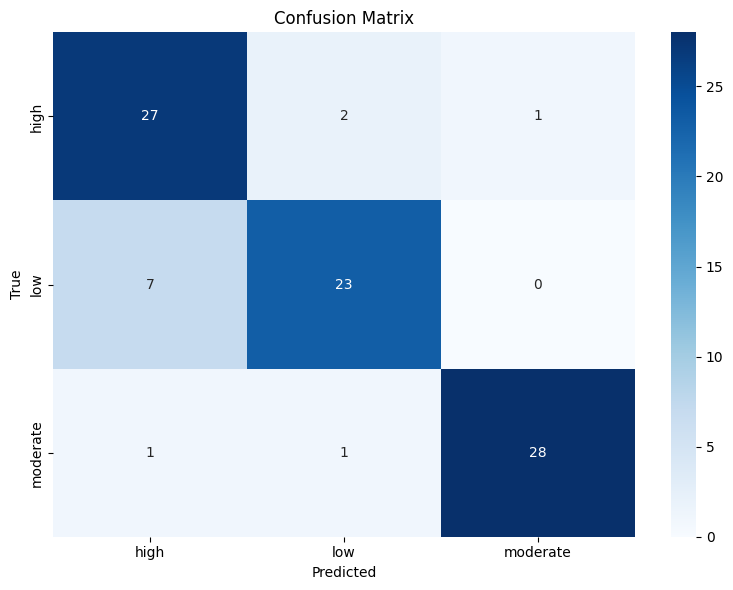


Classification Report:
              precision    recall  f1-score   support

        high       0.77      0.90      0.83        30
         low       0.88      0.77      0.82        30
    moderate       0.97      0.93      0.95        30

    accuracy                           0.87        90
   macro avg       0.87      0.87      0.87        90
weighted avg       0.87      0.87      0.87        90

Macro-Averaged F1 Score: 0.8671


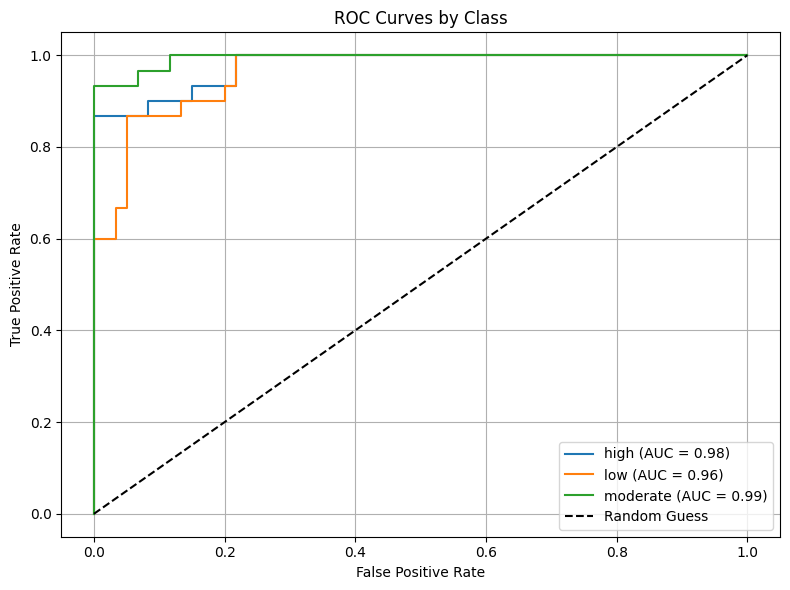

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization,
                                     Reshape, LSTM, Dropout, Dense)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
from sklearn.preprocessing import label_binarize

# ============ Parameters ============
IMG_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 200
NUM_CLASSES = 3  # low, moderate, high

# ============ Data Loaders ============
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    'train',  # folder with subfolders: low, moderate, high
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = val_gen.flow_from_directory(
    'validation',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = test_gen.flow_from_directory(
    'test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important for matching predictions to labels
)

# ============ Model Architecture (CNN-LSTM) ============
input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# CNN Feature Extractor
x = BatchNormalization()(input_layer)
x = Conv2D(64, (5, 7), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 3))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 3))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

# LSTM
x = Reshape((x.shape[1] * x.shape[2], x.shape[3]))(x)

# LSTM layers
x = Bidirectional(512, return_sequences=True)(x)



x = Bidirectional(256, return_sequences=True)(x)
x = Bidirectional(128)(x)

# Dense Layers
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.75)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

# Build and Compile Model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall'),
                  tf.keras.metrics.AUC(name='auc')
              ])
model.summary()

# ============ Training ============
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('cnn_lstm_best.h5', save_best_only=True)
]

model.fit(train_data,
          validation_data=val_data,
          epochs=EPOCHS,
          callbacks=callbacks,
          verbose=2)

# Save Final Model
model.save("cnn_lstm_final.h5")
print("Model saved as cnn_lstm_final.h5")

# ============ Evaluate on Test Data ============
loss, acc, prec, rec, auc_score = model.evaluate(test_data, verbose=2)
print(f"\nTest Accuracy: {acc*100:.2f}%")
print(f"Test Loss: {loss:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"AUC: {auc_score:.4f}")

# ============ Predictions ============
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_data.classes
class_labels = list(test_data.class_indices.keys())

# ============ Confusion Matrix ============
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# ============ Classification Report ============
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Macro-Averaged F1 Score
macro_f1 = f1_score(y_true, y_pred, average='macro')
print(f"Macro-Averaged F1 Score: {macro_f1:.4f}")

# ============ ROC Curve and AUC ============
y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_pred_probs[:, i])

plt.figure(figsize=(8, 6))
for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


Found 720 images belonging to 3 classes.
Found 90 images belonging to 3 classes.
Found 90 images belonging to 3 classes.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      6784      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 85, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 85, 64)       36928     
      

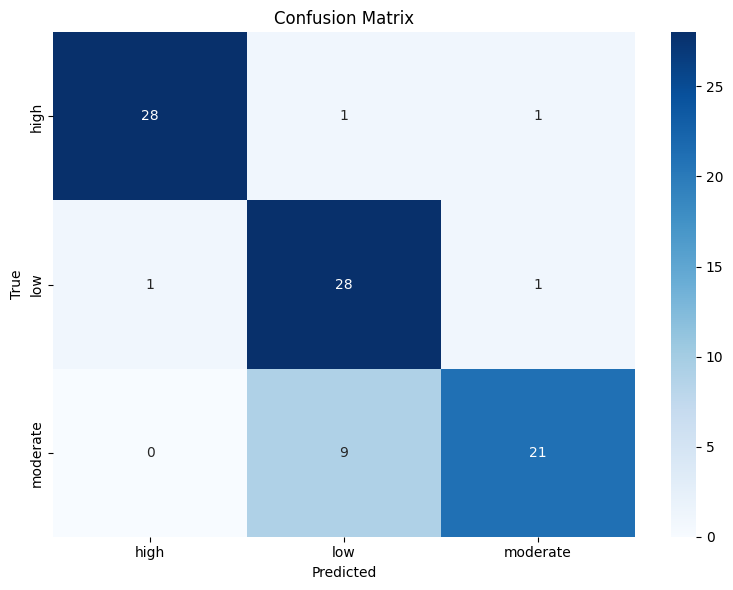


Classification Report:
              precision    recall  f1-score   support

        high       0.97      0.93      0.95        30
         low       0.74      0.93      0.82        30
    moderate       0.91      0.70      0.79        30

    accuracy                           0.86        90
   macro avg       0.87      0.86      0.86        90
weighted avg       0.87      0.86      0.86        90

Macro-Averaged F1 Score: 0.8550


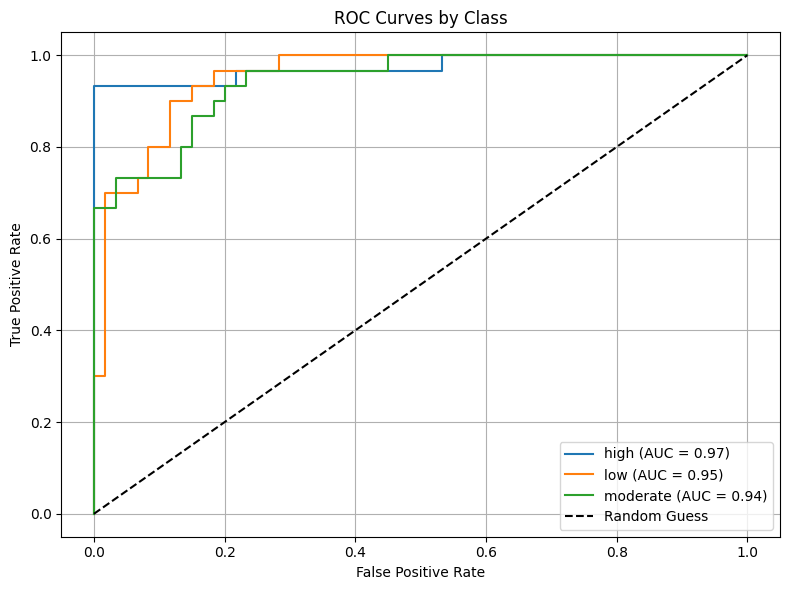

In [1]:
# Bidirectional LSTM
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization,
                                     Reshape, LSTM, Dropout, Dense)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras.layers import Bidirectional


# ============ Parameters ============
IMG_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 200
NUM_CLASSES = 3  # low, moderate, high

# ============ Data Loaders ============
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    'train',  # folder with subfolders: low, moderate, high
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = val_gen.flow_from_directory(
    'validation',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = test_gen.flow_from_directory(
    'test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important for matching predictions to labels
)

# ============ Model Architecture (CNN-LSTM) ============
input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# CNN Feature Extractor
x = BatchNormalization()(input_layer)
x = Conv2D(64, (5, 7), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 3))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 3))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

# LSTM
x = Reshape((x.shape[1] * x.shape[2], x.shape[3]))(x)

# LSTM layers
x = Bidirectional(LSTM(512, return_sequences=True))(x)
x = Bidirectional(LSTM(256, return_sequences=True))(x)
x = Bidirectional(LSTM(128))(x)

# Dense Layers
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.75)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

# Build and Compile Model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall'),
                  tf.keras.metrics.AUC(name='auc')
              ])
model.summary()

# ============ Training ============
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('cnn_lstm_best.h5', save_best_only=True)
]

model.fit(train_data,
          validation_data=val_data,
          epochs=EPOCHS,
          callbacks=callbacks,
          verbose=2)

# Save Final Model
model.save("cnn_lstm_final.h5")
print("Model saved as cnn_lstm_final.h5")

# ============ Evaluate on Test Data ============
loss, acc, prec, rec, auc_score = model.evaluate(test_data, verbose=2)
print(f"\nTest Accuracy: {acc*100:.2f}%")
print(f"Test Loss: {loss:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"AUC: {auc_score:.4f}")

# ============ Predictions ============
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_data.classes
class_labels = list(test_data.class_indices.keys())

# ============ Confusion Matrix ============
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# ============ Classification Report ============
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Macro-Averaged F1 Score
macro_f1 = f1_score(y_true, y_pred, average='macro')
print(f"Macro-Averaged F1 Score: {macro_f1:.4f}")

# ============ ROC Curve and AUC ============
y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_pred_probs[:, i])

plt.figure(figsize=(8, 6))
for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Bidirectional LSTM
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization,
                                     Reshape, LSTM, Dropout, Dense)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras.layers import Bidirectional


# ============ Parameters ============
IMG_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 200
NUM_CLASSES = 3  # low, moderate, high

# ============ Data Loaders ============
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    'train',  # folder with subfolders: low, moderate, high
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = val_gen.flow_from_directory(
    'validation',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = test_gen.flow_from_directory(
    'test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important for matching predictions to labels
)

# ============ Model Architecture (CNN-LSTM) ============
input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# CNN Feature Extractor
x = BatchNormalization()(input_layer)
x = Conv2D(64, (5, 7), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 3))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 3))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

# LSTM
x = Reshape((x.shape[1] * x.shape[2], x.shape[3]))(x)

# LSTM layers
x = Bidirectional(LSTM(512, return_sequences=True))(x)
x = Bidirectional(LSTM(256, return_sequences=True))(x)
x = Bidirectional(LSTM(128))(x)

# Dense Layers
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.75)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

# Build and Compile Model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall'),
                  tf.keras.metrics.AUC(name='auc')
              ])
model.summary()

# ============ Training ============
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('cnn_lstm_best.h5', save_best_only=True)
]

model.fit(train_data,
          validation_data=val_data,
          epochs=EPOCHS,
          callbacks=callbacks,
          verbose=2)

# Save Final Model
model.save("cnn_Bilstm_final2405.h5")
print("cnn_Bilstm_final2405.h5")